In [29]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [30]:
def read_txt(datafile):
    with open(datafile, "r") as file:
        lines = file.readlines()
        data = [[float(num) for num in line.split()] for line in lines]
    return data

In [31]:
def cross_dot(b):
    # d(axb)/d(a)
    cross_dot = np.array([[0, b[2], -b[1]],
                    [-b[2], 0, b[0]],
                    [b[1], -b[0], 0]])
    return cross_dot

def cross2_dot(a, b):
    #d(ax(axb))/d(a)
    cross2_dot = np.array([[a[1]*b[1]+a[2]*b[2], a[0]*b[1]-2*a[1]*b[0], a[0]*b[2]-2*a[2]*b[0]],
                           [-2*a[0]*b[1]+a[1]*b[0], a[0]*b[0]+a[2]*b[2], a[1]*b[2]-2*a[2]*b[1]],
                           [-2*a[0]*b[2]+a[2]*b[0], -2*a[1]*b[2]+a[2]*b[1], a[0]*b[0]+a[1]*b[1]]])
    return cross2_dot

def wedge(a):
    Ahat = np.array([[0, -a[2], a[1]],
                    [a[2], 0, -a[0]],
                    [-a[1], a[0], 0]])
    return Ahat

In [32]:
def dynamics(dt, state, RW, w_input_noise, a_input_noise, num_imus):
    state_next = np.zeros(9+6*num_imus) 
    state_next[0:3] = state[0:3] + state[3:6] * dt                                     # omega
    state_next[3:6] = w_input_noise * np.random.randn(3)                               # omega_dot
    state_next[6:9] = a_input_noise * np.random.randn(3)                               # specific force
    state_next[9:9+6*num_imus] = state[9:9+6*num_imus] + RW * np.random.randn(len(RW)) # Rate random walk state
    return state_next

def dynamics_est(dt, state, num_imus):
    state_next = np.zeros((9+6*num_imus))
    state_next[0:3] = state[0:3] + state[3:6] * dt          # omega
    state_next[3:6] = np.zeros(3)                           # omega_dot
    state_next[6:9] = np.zeros(3)                           # specific force
    state_next[9:9+6*num_imus] = state[9:9+6*num_imus]      # Rate random walk state
    return state_next

def Jacobian_f(dt, num_imus):
    F = np.zeros((9+6*num_imus, 9+6*num_imus))
    F[0:3, 0:3]            = np.eye(3)
    F[0:3, 3:6]            = dt * np.eye(3)
    F[9:9+6*num_imus, 9:9+6*num_imus] = np.eye(6*num_imus)
    return F

In [33]:
def measurement(state, pos_r, Rb_si, WN, num_imus):
    meas = np.zeros(6*num_imus)
    for i in range(num_imus):
        Rb_si_sub = Rb_si[i]
        r_sub = pos_r[i]
        sf = state[6:9]
        omega = state[0:3]
        omega_dot = state[3:6]
        RW_sub = state[9+i*6:15+6*i]
        s_i = Rb_si_sub @ (sf + wedge(omega) @ wedge(omega) @ r_sub + wedge(omega_dot) @ r_sub + WN[i*num_imus:3+i*num_imus]*np.random.randn(3)) + RW_sub[0:3]
        omega_i = Rb_si_sub @ omega + WN[3+i*num_imus:6+i*num_imus]*np.random.randn(3) + RW_sub[3:6]
        meas[i*6:6+i*6] = np.concatenate((s_i, omega_i))
    return meas


def measurement_est(state, pos_r, Rb_si, num_imus):
    meas = np.zeros(6*num_imus)
    H = np.zeros((6*num_imus, 9+6*num_imus))
    for i in range(num_imus):
        Rb_si_sub = Rb_si[i]
        r_sub = pos_r[i]
        sf = state[6:9]
        omega = state[0:3]
        omega_dot = state[3:6]
        RW_sub = state[9+i:15+6*i]
        H_i = np.zeros((6, 9+6*num_imus))
        H_i[0:3, 0:3] = Rb_si_sub @ cross2_dot(omega, r_sub)
        H_i[0:3, 3:6] = Rb_si_sub @ cross_dot(r_sub)
        H_i[0:3, 6:9] = Rb_si_sub
        H_i[0:3, 12+i*6:15+i*6] = np.eye(3)
        H_i[3:6, 0:3] = Rb_si_sub
        H_i[3:6, 9+i*6:12+i*6] = np.eye(3)
        meas[i*6:6+i*6] = H_i @ state
        H[i*6:6+i*6, :] = H_i
    return meas, H

In [34]:
# measurements
measurements = np.array(read_txt("data/imu.txt"))

In [35]:
num_imus = 3

# Other DISI Kit params
# Positions in 3xN where each column is position of 1 IMU
pos_r = np.array([[0.0, 0.0, 0.1],
         [0.0, 0.1, 0.0],
         [0.0, 0.0, 0.0]])
Rb_si = [np.eye(3), np.eye(3), np.eye(3)] # Rotation matrix

w_input_noise = 1e-3
a_input_noise = 1e-3
RW = 1e-4 * np.ones(6*num_imus)
WN = 1e-3 * np.ones(6*num_imus)

dt = 0.01
time = np.arange(0, 360, 0.01)

# state: omega, alpha, accel, 6 x number_of_imus (RW)
state = np.zeros(9 + 6*num_imus)
state_est = np.zeros(9 + 6*num_imus)
omega = np.array([1, 1, 1])
omega_dot = np.array([0, 0, 0])
sf = np.array([0, 0, 1])
state_est[0:3] = omega
state_est[6:9] = sf
state[0:3] = omega
state[6:9] = sf
state_hist = np.zeros((len(time), 9 + 6*num_imus))
state_est_hist = np.zeros((len(time), 9 + 6*num_imus))
meas = np.zeros(6*num_imus)
meas_hist = np.zeros((len(time),6*num_imus))

# Initial state Coveriance
P_est = np.eye(9 + 6*num_imus)

# Covariance of process noise covariance
Q = np.zeros((9 + 6*num_imus, 9 + 6*num_imus))
Q[3:6,3:6] = w_input_noise ** 2 * np.eye(3)
Q[6:9,6:9] = a_input_noise ** 2 * np.eye(3)
Q[9:9+6*num_imus, 9:9+6*num_imus] = np.diag(RW**2)

# Covariance of measurement noise covariance
R = np.eye(6*num_imus)*WN**2

for i in range(len(time)):
    state = dynamics(dt, state, RW, w_input_noise, a_input_noise, num_imus)
    state_hist[i] = state
    # Prediction step
    state_pred = dynamics_est(dt, state_est, num_imus)
    F = Jacobian_f(dt, num_imus)
    P_pred = np.dot(np.dot(F, P_est), F.T) + Q

    # Update step
    meas, H = measurement_est(state_pred, pos_r, Rb_si, num_imus)
    y = measurements[i] - meas
    S = np.dot(np.dot(H, P_pred), H.T) + R
    K = np.dot(np.dot(P_pred, H.T), np.linalg.inv(S))
    state_est = state_pred + np.dot(K, y)
    P_est = np.dot(np.eye(len(P_est))- np.dot(K,H), P_pred)
    meas_hist[i] = meas
    state_est_hist[i] = state_est

Text(0, 0.5, '$\\omega$ (rad/s)')

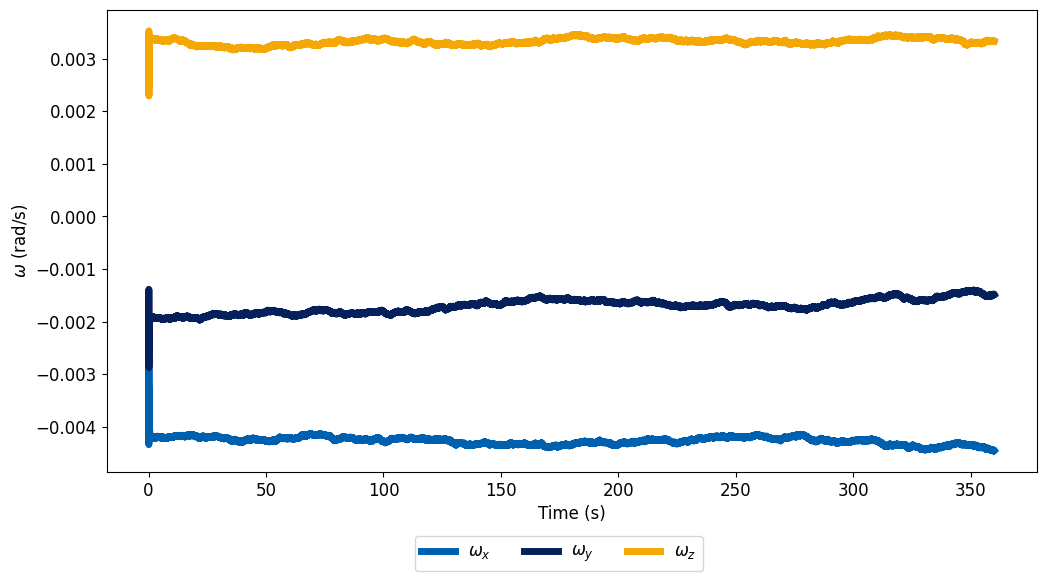

In [67]:
fig1, ax1 = plt.subplots(figsize = (12, 6))
ax1.plot(time[10:], state_est_hist[10:,0], linewidth=5, color = "#0060B0", label = "$\omega_x$")
ax1.plot(time[10:], state_est_hist[10:,1], linewidth=5, color = "#06205C", label = "$\omega_y$")
ax1.plot(time[10:], state_est_hist[10:,2], linewidth=5, color = "#F5A706", label = "$\omega_z$")
ax1.tick_params(axis='both', which='major', labelsize=12)
ax1.legend(ncol=3, fancybox=True, frameon=True, fontsize=12, bbox_to_anchor=(0.65, -0.12))
ax1.set_xlabel("Time (s)", fontsize=12)
ax1.set_ylabel("$\omega$ (rad/s)", fontsize=12)

Text(0, 0.5, '$\\dot{\\omega}$ (rad/$s^2$)')

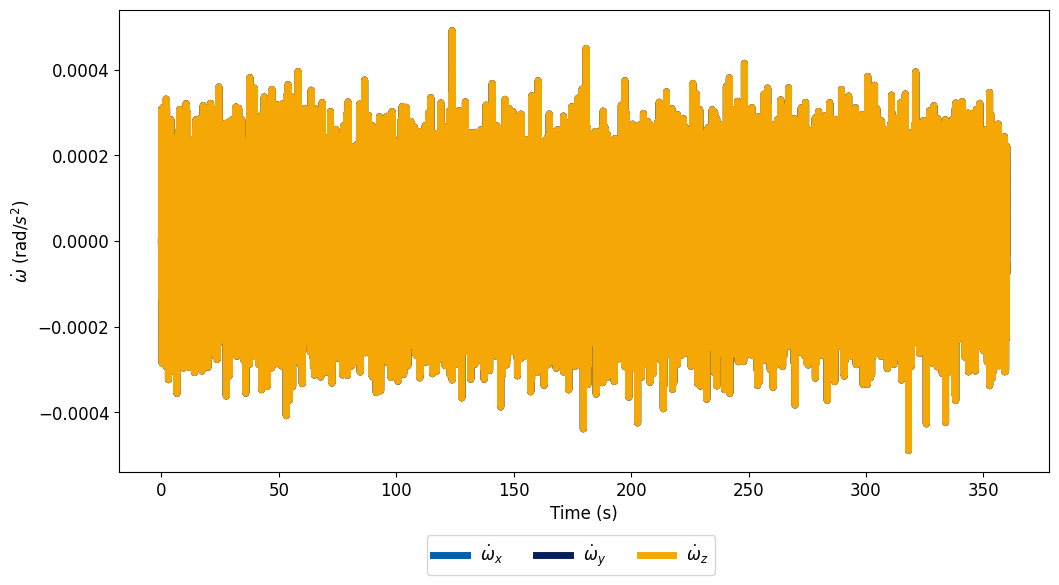

In [69]:
# plt.figure(figsize = (12, 6))
# plt.plot(time, state_est_hist[:,3])
# plt.plot(time, state_est_hist[:,4])
# plt.plot(time, state_est_hist[:,5])
# plt.title("omega dot")

fig2, ax2 = plt.subplots(figsize = (12, 6))
ax2.plot(time, state_est_hist[:,3], linewidth=5, color = "#0060B0", label = "$\dot{\omega}_x$")
ax2.plot(time, state_est_hist[:,3], linewidth=5, color = "#06205C", label = "$\dot{\omega}_y$")
ax2.plot(time, state_est_hist[:,3], linewidth=5, color = "#F5A706", label = "$\dot{\omega}_z$", alpha=0.5)
ax2.tick_params(axis='both', which='major', labelsize=12)
ax2.legend(ncol=3, fancybox=True, frameon=True, fontsize=12, bbox_to_anchor=(0.65, -0.12))
ax2.set_xlabel("Time (s)", fontsize=12)
ax2.set_ylabel("$\dot{\omega}$ (rad/$s^2$)", fontsize=12)

Text(0.5, 1.0, 'specific force')

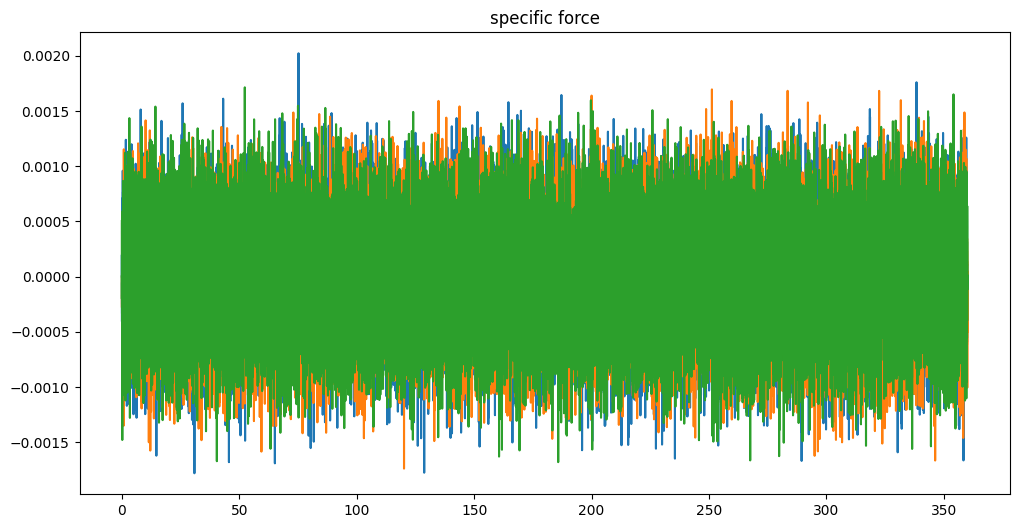

In [38]:
plt.figure(figsize = (12, 6))
plt.plot(time, state_est_hist[:,6])
plt.plot(time, state_est_hist[:,7])
plt.plot(time, state_est_hist[:,8])
plt.title("specific force")

Text(0.5, 1.0, 'omega')

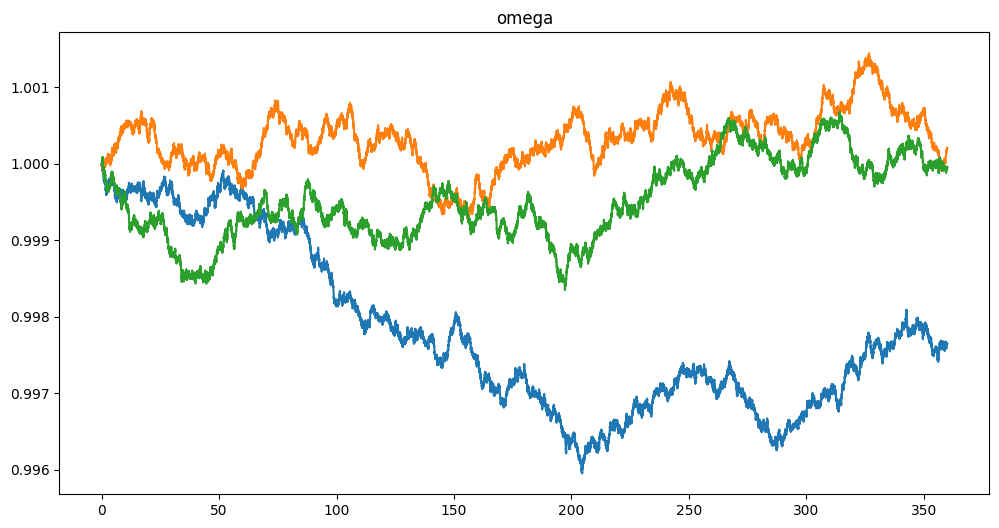

In [39]:
plt.figure(figsize = (12, 6))
plt.plot(time, state_hist[:,0])
plt.plot(time, state_hist[:,1])
plt.plot(time, state_hist[:,2])
plt.title("omega")

Text(0.5, 1.0, 'omega dot')

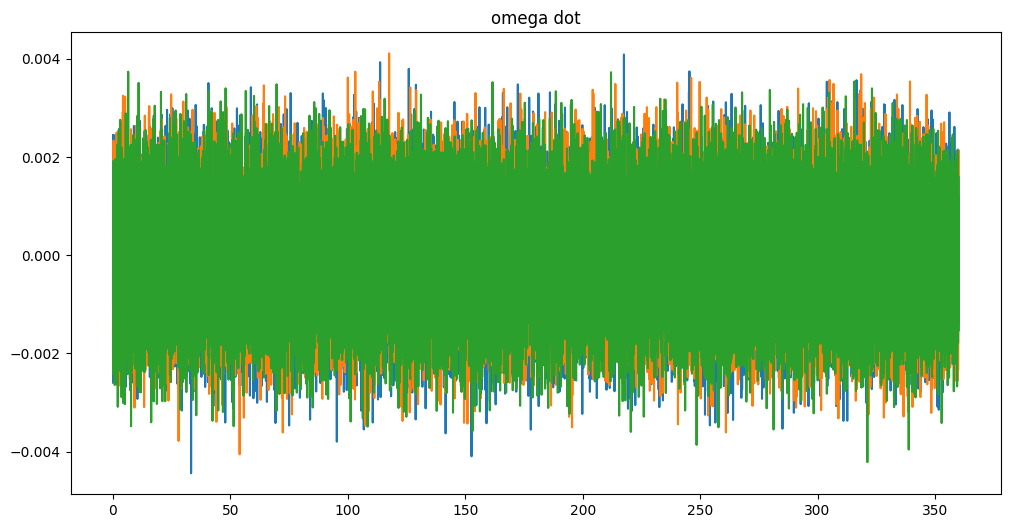

In [40]:
plt.figure(figsize = (12, 6))
plt.plot(time, state_hist[:,3])
plt.plot(time, state_hist[:,4])
plt.plot(time, state_hist[:,5])
plt.title("omega dot")

Text(0.5, 1.0, 'specific force')

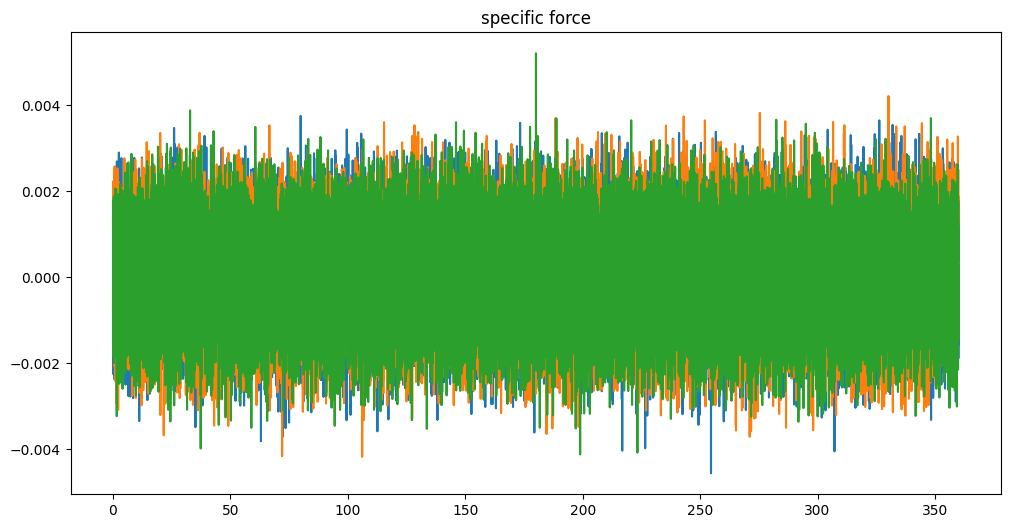

In [41]:
plt.figure(figsize = (12, 6))
plt.plot(time, state_hist[:,6])
plt.plot(time, state_hist[:,7])
plt.plot(time, state_hist[:,8])
plt.title("specific force")

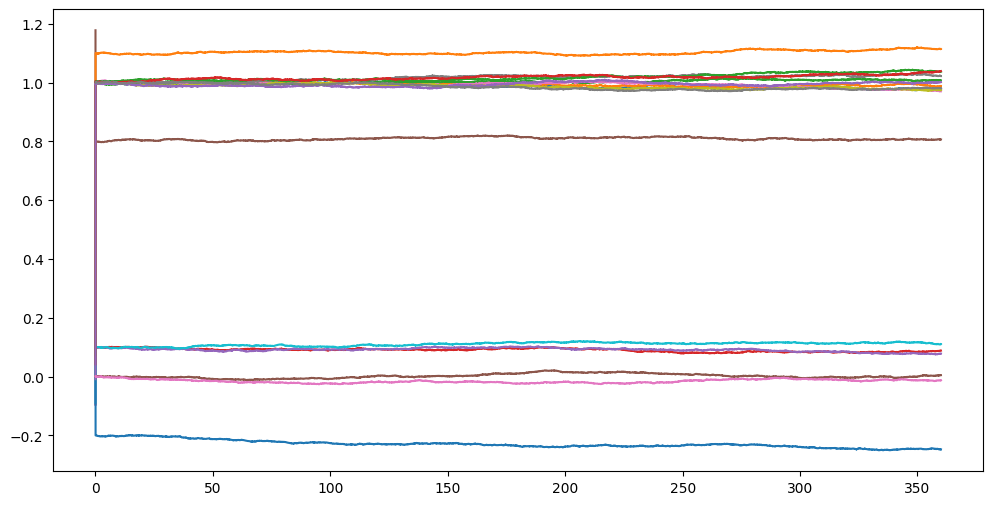

In [42]:
plt.figure(figsize = (12, 6))
plt.plot(time, state_est_hist[:,9])
plt.plot(time, state_est_hist[:,10])
plt.plot(time, state_est_hist[:,11])
plt.plot(time, state_est_hist[:,12])
plt.plot(time, state_est_hist[:,13])
plt.plot(time, state_est_hist[:,14])
plt.plot(time, state_est_hist[:,15])
plt.plot(time, state_est_hist[:,16])
plt.plot(time, state_est_hist[:,17])
plt.plot(time, state_est_hist[:,18])
plt.plot(time, state_est_hist[:,19])
plt.plot(time, state_est_hist[:,20])
plt.plot(time, state_est_hist[:,21])
plt.plot(time, state_est_hist[:,22])
plt.plot(time, state_est_hist[:,23])
plt.plot(time, state_est_hist[:,24])
plt.plot(time, state_est_hist[:,25])
plt.plot(time, state_est_hist[:,26])

Text(0.5, 1.0, 'specific force measurement estimates')

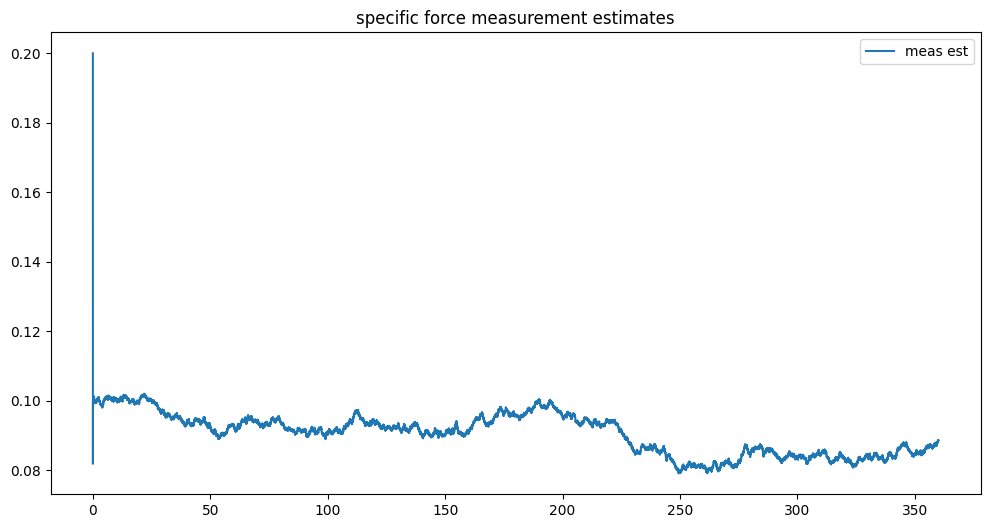

In [43]:
plt.figure(figsize = (12, 6))
plt.plot(time, meas_hist[:,0], label = 'meas est')
# plt.plot(time, measurements[:,0], label = 'meas')
# plt.plot(time, meas_hist[:,1], label = 'y')
# plt.plot(time, meas_hist[:,2], label = 'z')
# plt.plot(time, meas_hist[:,6], label = 'x')
# plt.plot(time, meas_hist[:,7], label = 'y')
# plt.plot(time, meas_hist[:,8], label = 'z')
# plt.plot(time, meas_hist[:,12], label= 'x')
# plt.plot(time, meas_hist[:,13], label= 'y')
# plt.plot(time, meas_hist[:,14], label= 'z')
plt.legend()
plt.title("specific force measurement estimates")